# 3DMNN
#### EXPERIMENTS

In [1]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper, generate_mitsuba_xml

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

class_name = input('Give me the class name (e.g. "chair"): ').lower()

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)


# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 100,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))

# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()

ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 70, verbose=False)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

Give me the class name (e.g. "chair"): car
<generator object files_in_subdirs at 0x7f35a072c360>
7497 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-70


Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [7]:
print(all_pc_data.point_clouds[-1].shape)

import random as rd

reconstruction_from = np.asarray(ae.reconstruct(all_pc_data.point_clouds[rd.randint(0, 4000)].reshape(1,2048,3)))
reconstruction_to = np.asarray(ae.reconstruct(all_pc_data.point_clouds[rd.randint(0, 4000)].reshape(1,2048,3)))

#data for the latent gan
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    print(_from.shape)
    print(_to.shape)
    
    interpolations = ae.interpolate(_from, _to, steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)
        generate_mitsuba_xml(interpolation, class_name, i)
        
    print("Interpolation Complete")
    print(interpolations.shape)
    
interpolate(reconstruction_from[0], reconstruction_to[0], steps=60)

(2048, 3)
Generating interpolations
(1, 2048, 3)
(1, 2048, 3)
Interpolation Complete
(62, 2048, 3)


Create and Configure GAN...

In [3]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(7497, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


1 (-12.353025536409161, -2.1928912107113923)
INFO:tensorflow:./models_checkpoints/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (-16.13181278049546, -4.944366288665157)
3 (-14.51531145876686, -5.8623663211028845)
4 (-12.786835292841763, -6.558434419183923)
5 (-11.069075213182693, -6.888242007902004)
INFO:tensorflow:./models_checkpoints/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.
6 (-9.476514515460737, -6.785150838378292)
7 (-8.085187646366606, -6.216206870623083)
8 (-6.940248582187115, -5.123526137947236)
9 (-6.091113720964265, -3.676035020175396)
10 (-5.489669646192717, -2.0607799651638774)
INFO:tensorflow:./models_checkpoints/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
11 (-5.069323949365808, -0.4900270224792645)
12 (-4.792104900283301, 0.8426882131587738)
13 (-4.595209092901857, 1.8282254030240461)
14 (-4.434646673650549, 2.51979739073939)
15 (-4.279577399260246, 3.0804951478970932)
16 (-4.163547061

167 (-0.8307420127343812, -0.459715872002928)
168 (-0.853497627197496, -0.4032198394704985)
169 (-0.8316361444108438, -0.40687767701260996)
170 (-0.8229610379910309, -0.3928448689863986)
171 (-0.8294060516277416, -0.3854360961474028)
172 (-0.8348599196280408, -0.44774994854159)
173 (-0.8354042052422594, -0.3386927116037215)
174 (-0.8347729080475417, -0.4139428405753718)
175 (-0.8193523395781549, -0.2979996995437865)
176 (-0.8361949044586028, -0.3953572207649282)
177 (-0.8098295791037131, -0.3654370281920337)
178 (-0.8279750907181094, -0.37549649709023086)
179 (-0.8247969618579686, -0.34111718378411043)
180 (-0.834476504149853, -0.35155666229508864)
181 (-0.8234711577428268, -0.34707611789239334)
182 (-0.8274096338540916, -0.34731898231794367)
183 (-0.8210755906649084, -0.41453238201621395)
184 (-0.8049473238471371, -0.4144235995391871)
185 (-0.8021990248820926, -0.3979585579777724)
186 (-0.8124900052211429, -0.37820581071728826)
187 (-0.8229875544573637, -0.39659531774536877)
188 (-0.8

332 (-0.6844665692156593, -0.07541294022925799)
333 (-0.6923200982129014, -0.11704978079928847)
334 (-0.6889286817320242, -0.07396943939087175)
335 (-0.6934359625681935, -0.09808129291893952)
336 (-0.6837879495332705, -0.08332122171972722)
337 (-0.6902743341938761, -0.051552304035465187)
338 (-0.6810467139186475, -0.04608274359551365)
339 (-0.6799630748745579, -0.10184528084234303)
340 (-0.6905825110089859, -0.09827197773144548)
341 (-0.6849679194840809, -0.11061403530043544)
342 (-0.6861861072130652, -0.08619933043787843)
343 (-0.6881652768426294, -0.08778883609139429)
344 (-0.6772932884277113, -0.10149050807117815)
345 (-0.6856500198377059, -0.0671804051271221)
346 (-0.6853480343050604, -0.10046451377538626)
347 (-0.680049381800146, -0.10029289180775416)
348 (-0.677797366708717, -0.07174567471027074)
349 (-0.6732038487523995, -0.08791360012630638)
350 (-0.6762811585560741, -0.059848019834482825)
INFO:tensorflow:./models_checkpoints/models.ckpt-350 is not in all_model_checkpoint_paths

497 (-0.6013426542682135, -0.1631751285253355)
498 (-0.6012709036769482, -0.17804916773066423)
499 (-0.6078162615331227, -0.1734869679648604)
500 (-0.5928201545404908, -0.15508033860249806)
INFO:tensorflow:./models_checkpoints/models.ckpt-500 is not in all_model_checkpoint_paths. Manually adding it.
501 (-0.6005857238833536, -0.15517693906772456)
502 (-0.5997789218121727, -0.17659985388460375)
503 (-0.5912998188662049, -0.1563676436675475)
504 (-0.6029725466798616, -0.15992803899133765)
505 (-0.6029206894388135, -0.13459956773475512)
506 (-0.6034954704294269, -0.16229650518238145)
507 (-0.5996458696438962, -0.1500545605867101)
508 (-0.5957946089290133, -0.13477134168298052)
509 (-0.5947564240270014, -0.11515756015784588)
510 (-0.6041928841763695, -0.1441409587610088)
511 (-0.5990051231128257, -0.14033873496739657)
512 (-0.593783176985363, -0.16105098212325333)
513 (-0.5923177787921573, -0.14428981723601386)
514 (-0.5933554120511817, -0.13890282669723433)
515 (-0.6013055789790698, -0.15

661 (-0.5698803561245835, -0.15127162680329892)
662 (-0.574868893263324, -0.14638441705438715)
663 (-0.5794821435573118, -0.13567120044635947)
664 (-0.5685284509754821, -0.1460103744378426)
665 (-0.5685972725384988, -0.1282043006246122)
666 (-0.5707397534943267, -0.11963771518644871)
667 (-0.570580754904139, -0.13179223209419505)
668 (-0.5680740969693101, -0.11706698624942226)
669 (-0.5773172322535675, -0.14010796685946866)
670 (-0.5773302602687939, -0.15447004279434282)
671 (-0.5655445018470687, -0.14787978061393603)
672 (-0.5695072500497703, -0.13125134782003076)
673 (-0.5723474757783364, -0.1683622601148266)
674 (-0.5722202770661988, -0.12299626118709776)
675 (-0.5694254502754084, -0.11268342457611688)
676 (-0.5647860689451231, -0.1612328897986636)
677 (-0.5635892808837378, -0.10883203366983857)
678 (-0.5755981554921041, -0.16313261658753325)
679 (-0.5655672196173828, -0.1470793448638596)
680 (-0.5637883637975526, -0.12286474965762771)
681 (-0.5608559610859659, -0.13482321055305985)

826 (-0.5397894422479924, -0.14308491984269764)
827 (-0.5470434545270548, -0.14873268932804165)
828 (-0.550997757871679, -0.1503019668661908)
829 (-0.5437742635707727, -0.1460330617057797)
830 (-0.5510991481726601, -0.14967172556625516)
831 (-0.5447299232418905, -0.1325555064484177)
832 (-0.5464672348243278, -0.13584376606565193)
833 (-0.5376103916424233, -0.14657216821640928)
834 (-0.5462244549053628, -0.14468513729188265)
835 (-0.54864842479661, -0.12224311424706806)
836 (-0.5435346622995082, -0.1438107832816223)
837 (-0.5361232295532354, -0.1756519254222012)
838 (-0.5415949187422758, -0.13688404513085448)
839 (-0.5422144530203519, -0.16249274747483683)
840 (-0.530102550983429, -0.15746401160355383)
841 (-0.5450636172454629, -0.12110028434669812)
842 (-0.5407003892348117, -0.11477976593645227)
843 (-0.549134618883965, -0.1272406095276343)
844 (-0.5399626769475488, -0.14034834184102563)
845 (-0.5423879837429764, -0.1520506647609224)
846 (-0.5441619155790982, -0.1598134898149327)
847 (

992 (-0.5050447849219277, -0.15226511822250866)
993 (-0.5029934240667612, -0.14967946523187944)
994 (-0.4982109389849157, -0.1302495033748998)
995 (-0.5064676255987794, -0.1337508184697804)
996 (-0.5078389570617036, -0.12267568815130765)
997 (-0.5012251070681835, -0.12878490230631107)
998 (-0.49220916788850055, -0.1299892820342875)
999 (-0.5076830881153978, -0.13986930163614703)
1000 (-0.5061794827448441, -0.14017854560941656)
INFO:tensorflow:./models_checkpoints/models.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.


/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


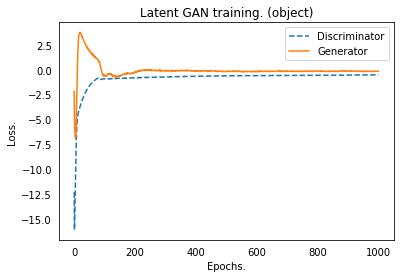

In [4]:
accum_syn_data = []
train_stats = []
n_epochs = 1000
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [6]:
syn_latent_data = gan.generate(5, params["noise_params"])
syn_data = ae.decode(syn_latent_data)
print(syn_data.shape)

reconstruct_obj(syn_data)
generate_mitsuba_xml(syn_data[0], class_name + "_gen", 0)


(5, 2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed


0

# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again